# 1. Preparing the Dataset

In [17]:
library(dplyr)
library(Rtsne)
library(cluster)
library(data.table)
library(ggplot2)

In [18]:
# Set the common exported dataset directory
dataset_dir <- file.path(getwd(), 'dataset', 'exported')

In [19]:
# Read the repeat dataset. It returns a data.table type
profile_csv <- file.path(dataset_dir, 'profile')
profile_df <- fread(profile_csv)

Convert these columns to type factor.

In [20]:
profile_df$gender <- factor(profile_df$gender)
profile_df$city_code <- factor(profile_df$city_code)

# 2. Clustering

<b>All codes below are based on this site: https://www.r-bloggers.com/clustering-mixed-data-types-in-r/ </b>

## 2.1. Gower Distance

Use gower distance because it can handle mixed data types.

Why I didn't use log transform:  
1. The dataset is from a pivot table. One customer may have bought only from the bath subcategory, but another one bought from kitchen and bags_men. There are a lot of zeros, which is normal for pivoting to get the sales per customer per subcategory. If I drop those zeroes, I would be left with no data at all.  
2. The means of each subcategory are near to each other.  
3. When I tested with the log transform, the medoids were only sales for ```total_bath```. It did not consider that some clusters have sales on 

In [21]:
gower_dist <- daisy(profile_df[, -c('customer_id')],
                    metric = 'gower')

## 2.2. Silhoutte Width
Use the silhoutte width to choose the final number of clusters to use.

In [22]:
# For k ranging from 2 to 10, use PAM
sil_width <- c(NA)
for (i in 2:10) {
    pam_fit <- pam(gower_dist, diss=TRUE, k=i)
    sil_width[i] <- pam_fit$silinfo$avg.width
}

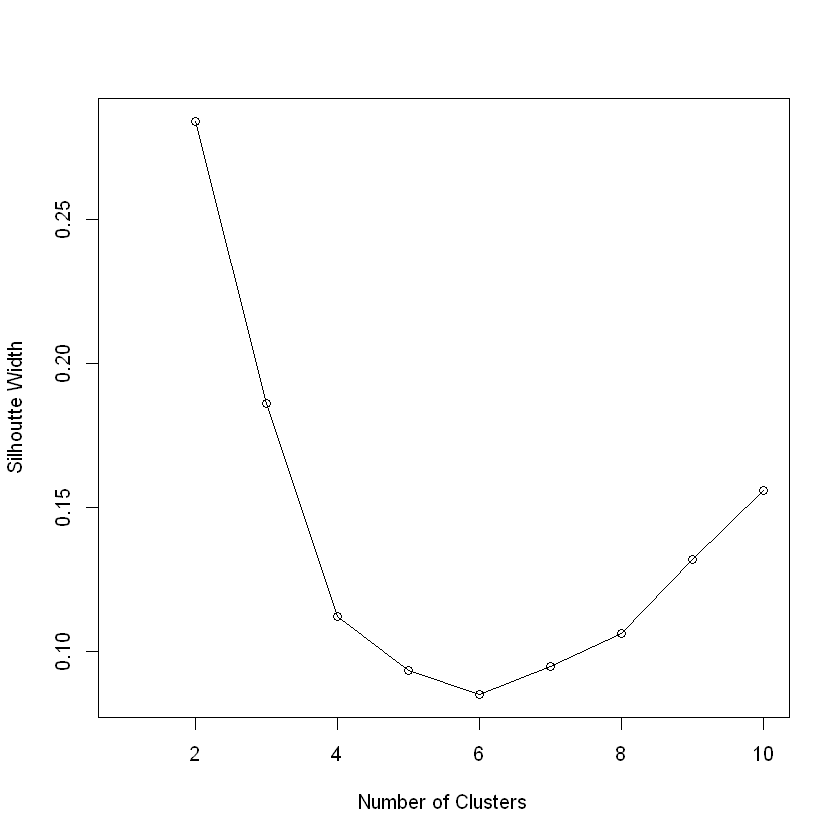

In [23]:
# Plot
plot(1:10, sil_width,
     xlab = "Number of Clusters",
     ylab = "Silhoutte Width")
lines(1:10, sil_width)

### Interpretation of the Silhoutte Width
Two clusters would output the best result followed by 3 clusters. However, having 10 clusters also produced a good measurement.

With this, I decided to <b>go with 10 clusters</b>. In the e-shop marketing view, grouping the customers into many small clusters is viable. Since this is an e-shop, recommendations in the site are not as costly as wide-reach marketing campaigns like television commercials, billboards, etc. If we are going with onsite recommendations, having 10 clusters would mean 10 targeted marketing campaigns with sure results.

## 2.3. Partitioning around Medoids
Do PAM with 10 clusters. Print out the summary and medoids of each cluster.

In [24]:
# Set the seed at a random number (in this case, 7) to always reproduce the result
set.seed(7)

In [25]:
pam_fit <- pam(gower_dist, diss = TRUE, k = 10)

In [26]:
pam_results <- profile_df %>%
    dplyr::select(-c(customer_id)) %>%
    mutate(cluster = pam_fit$clustering) %>% 
    group_by(cluster) %>%
    do(the_summary = summary(.))

In [27]:
pam_results$the_summary

[[1]]
 total_bags_men   total_bags_women   total_bath     total_clothing_kids
 Min.   :   0.0   Min.   :   0.0   Min.   :   0.0   Min.   :   0.0     
 1st Qu.:   0.0   1st Qu.:   0.0   1st Qu.:   0.0   1st Qu.:   0.0     
 Median :   0.0   Median :   0.0   Median :   0.0   Median :   0.0     
 Mean   : 470.6   Mean   : 335.7   Mean   : 406.5   Mean   : 348.4     
 3rd Qu.:   0.0   3rd Qu.:   0.0   3rd Qu.:   0.0   3rd Qu.:   0.0     
 Max.   :8121.8   Max.   :6856.5   Max.   :7602.4   Max.   :8141.6     
                                                                       
 total_clothing_men total_clothing_women total_furnishing total_kitchen   
 Min.   :   0.0     Min.   :   0.0       Min.   :   0.0   Min.   :   0.0  
 1st Qu.:   0.0     1st Qu.:   0.0       1st Qu.:   0.0   1st Qu.:   0.0  
 Median :   0.0     Median :   0.0       Median :   0.0   Median :   0.0  
 Mean   : 392.3     Mean   : 428.7       Mean   : 378.4   Mean   : 441.5  
 3rd Qu.:   0.0     3rd Qu.:   0.0       3r

In [28]:
profile_df[pam_fit$medoids, ]

customer_id,total_bags_men,total_bags_women,total_bath,total_clothing_kids,total_clothing_men,total_clothing_women,total_furnishing,total_kitchen,total_tools,gender,city_code,birth_year
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<int>
269430,0.000,0.000,0.00,0.00,110.5,0,0.00,0,0.000,F,5,1974
269136,0.000,0.000,0.00,0.00,0.0,0,0.00,0,415.480,M,4,1976
271969,0.000,0.000,0.00,77.35,0.0,0,0.00,0,0.000,M,5,1974
270344,0.000,0.000,320.45,0.00,0.0,0,0.00,0,0.000,F,7,1989
272759,0.000,0.000,0.00,0.00,0.0,0,0.00,0,93.925,F,1,1981
275049,0.000,184.535,0.00,0.00,0.0,0,0.00,0,0.000,M,2,1983
271405,98.345,0.000,0.00,0.00,0.0,0,0.00,0,0.000,F,10,1982
272047,0.000,0.000,0.00,384.54,0.0,0,0.00,0,0.000,F,9,1981
267222,0.000,0.000,0.00,0.00,0.0,0,0.00,0,132.600,M,8,1978


## 2.4. Plotting the Clusters
Use t-distributed stochastic neighbor embedding to plot the clusters using the gower distance.

In [29]:
tsne_obj <- Rtsne(gower_dist, is_distance = TRUE)

In [30]:
tsne_data <- tsne_obj$Y %>%
  data.frame() %>%
  setNames(c("X", "Y")) %>%
  mutate(cluster = factor(pam_fit$clustering),
         customer_id = profile_df$customer_id)

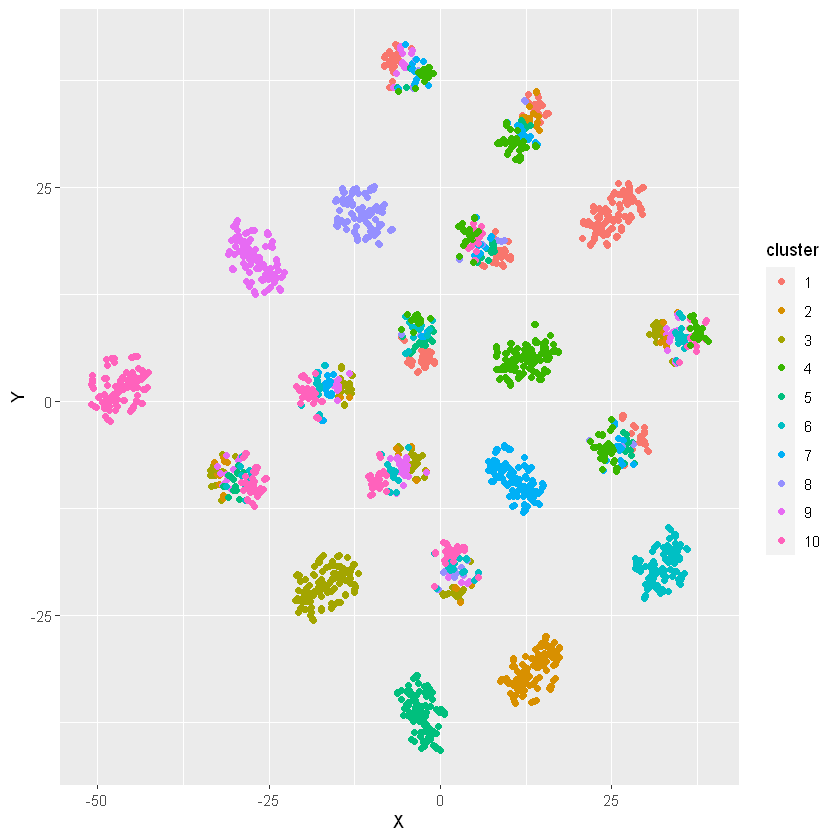

In [31]:
ggplot(aes(x = X, y = Y), data = tsne_data) +
  geom_point(aes(color = cluster))

## 2.5. Exporting the Cluster Results
Export the cluster results in CSV format. The file will then be read in the analysis python notebook.

In [32]:
write.csv(tsne_data, file.path(dataset_dir, 'profile_tsne_data'), row.names=TRUE)